In [51]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imp
imp.reload(rmtchem)
plt.rcParams.update({'font.size': 16})

In the absence of driving, the steady state is determined by the free energies, Xs=np.exp(-G). In this case, the eigenvalues of the Jacobian are real and negative definite.

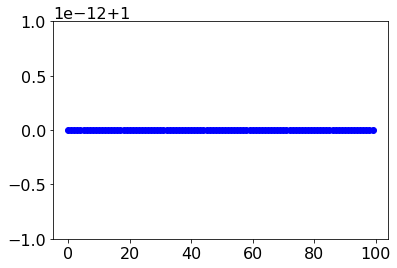

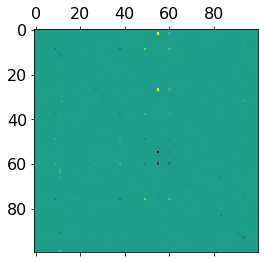

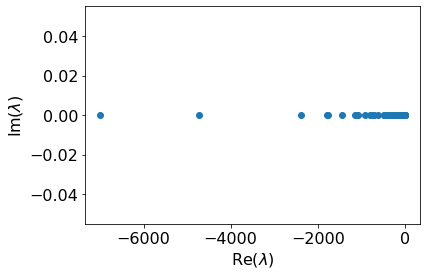

4.962391546946412e-13 1.621728430981133e-14


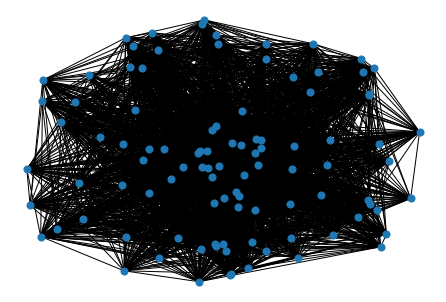

In [2]:
n=100
c=5
nr=int(c*n)

np.random.seed(2)
eta,nu,k,G=rmtchem.get_network(n,nr)
X0=np.exp(-G)
XD1=np.zeros(n)
XD2=np.zeros(n)
Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2).x
plt.plot(Xs2/X0,'bo')
plt.show()
plt.matshow(rmtchem.jac(Xs2,eta,nu,k,XD1,XD2))
plt.show()
evals=np.linalg.eig(rmtchem.jac(Xs2,eta,nu,k,XD1,XD2))
order=np.argsort(np.abs(-1/np.real(evals[0])))
tau=np.real(evals[0][order[:-1]])
im=np.imag(evals[0][order[:-1]])
plt.xlabel('$\mathrm{Re}(\lambda)$')
plt.ylabel('$\mathrm{Im}(\lambda)$')
plt.scatter(x=tau,y=im)
plt.savefig('plots/fig1.pdf')
plt.show()
g=nx.from_numpy_matrix(rmtchem.jac(np.exp(-G),eta,nu,k,XD1,XD2))
nx.draw(g,node_size=50)
plt.savefig('plots/fig0.pdf')
r=rmtchem.rates(Xs2,eta,nu,k)
print(np.linalg.norm((r[::2]-r[1::2])), np.linalg.norm((r[::2]-r[1::2])/r[::2]))

When we introduce small driving in the same network, the steady state is perturbed and some eigenvalues become complex. We can find the steady state with root finding, and the same steady state is found by numerical integration.

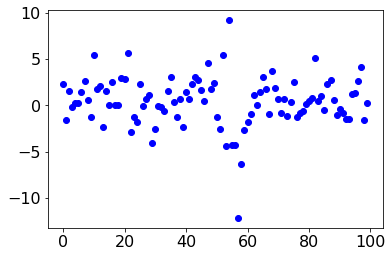

Calculated dynamics in  2.9275454399999994 seconds


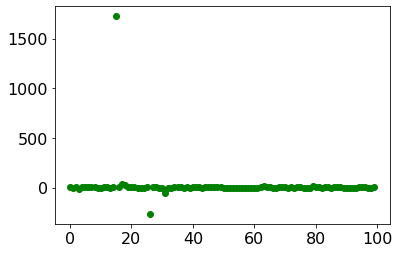

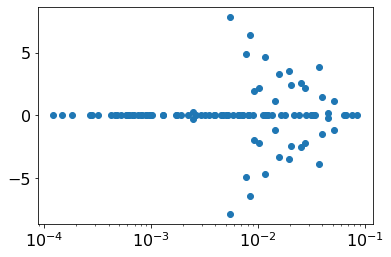

-11.762077182145166


In [3]:
np.random.seed(1)
eta,nu,k,G=rmtchem.get_network(n,nr)

drive0=1e3
drive=3

XD1=np.zeros(n)
XD2=np.zeros(n)
ndrives=10
inds=np.random.choice(range(n),size=ndrives,replace=False)
scales=np.exp(-G[inds])
XD2[inds]=drive0
XD1[inds]=scales*drive*drive0

X0=np.exp(-G)
Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2).x
plt.plot(Xs2/X0,'bo')
plt.show()

t1=100
dt=1
start=timeit.default_timer()
Xs3,success=rmtchem.integrate(X0,eta,nu,k,XD1,XD2,t1,dt)
stop=timeit.default_timer()
print("Calculated dynamics in ", stop-start, "seconds")
plt.plot(Xs3[-1]/Xs2,'go')
plt.show()
evals,evecs=np.linalg.eig(rmtchem.jac(Xs3[-1],eta,nu,k,XD1,XD2))
plt.xscale('log')
plt.scatter(x=-1/np.real(evals),y=np.imag(evals))
plt.show()
print(np.max(np.real(evals)))

Adiabatically turning on driving then increasing driving amplitude, track the maximum eigenvalues

Saddle-node for iseed=1 around m=140 with 
inds=np.argsort(np.sum(eta+nu,axis=0))[-ndrives:]
n=100 c=2
seed0=1 numseeds=10 ndrives=3
steps=100 d0min=-1 d0max=3
steps2=200 dmin=1 dmax=20!

TODO: make this an quasistatic function, taking d0min, d0max, d1min, d1max

27.355	2	1



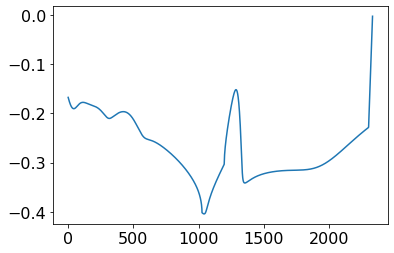

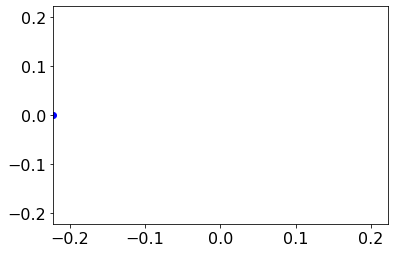

(-0.0025568317014260655+2.7753492655198033j)
True 0.0008124704649364149


Integration: 100%|##############################################| Time: 0:03:04


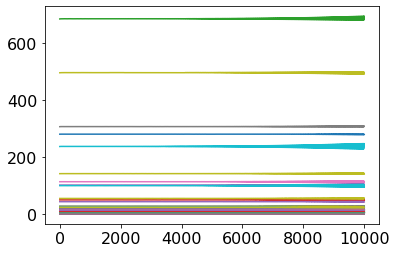

False 0.0008046655048154033


In [59]:
filebase='data/test'
file=open(filebase+'out.dat','r')
[n,nr,nd,seed,steps,skip,d0,d1max]=np.array(file.readline().split(),dtype=float)
[n,nr,nd,seed,steps,skip]=np.array([n,nr,nd,seed,steps,skip],dtype=int)
print(file.readline())
file.close()
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
d1min=1
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
evals=np.load(filebase+'evals.npy')
Xs=np.load(filebase+'Xs.npy')
XD1s=np.zeros((steps,n))
XD2s=np.zeros((steps,n))
inds=np.argsort(np.exp(-G))[:nd]
scales=np.exp(-G[inds])
for m in range(steps):
    XD1s[m,inds]=d1s[m]*d0*scales
    XD2s[m,inds]=d0
plt.plot(np.max(np.real(evals),axis=1))
plt.show()
lim=1.1*np.max(np.abs(evals[-1,np.argsort(np.real(evals[-1]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.plot(np.real(evals[-1]),np.imag(evals[-1]),'bo')
plt.show()
print(evals[-1,np.argsort(np.real(evals[-1]))[-1]])

mmax=len(Xs)
m=mmax-1
X0=Xs[m]
XD1=XD1s[(m+1)*skip]
XD2=XD2s[(m+1)*skip]
sol=rmtchem.steady(X0, eta, nu, k, XD1,XD2)
print(sol.success,np.min(sol.x),flush=True)
X0=Xs[m]
X2,success=rmtchem.integrate(X0, eta, nu, k, XD1,XD2,1000,0.1,prog=True)
plt.plot(X2)
plt.show()
sol=rmtchem.steady(X2[-1], eta, nu, k, XD1,XD2)
print(sol.success,np.min(sol.x),flush=True)

In [58]:
seeds=np.loadtxt('data/100/seeds.txt',dtype=int)
print('seed\tsubcrit\thopf')
for seed in seeds:
    filebase='data/100/'+str(seed)
    evals1=np.load(filebase+'evals1.npy')
    evals2=np.load(filebase+'evals2.npy')
    print('%i\t%i\t%i'%(seed,np.max(np.abs(np.max(np.real(evals1),axis=1)-np.max(np.real(evals2),axis=1)))>1e-2,np.max(np.real(evals1))>0))

seed	subcrit	hopf
2	0	1
17	0	1
35	1	0
42	1	1
46	0	1
58	1	0
59	1	0
62	1	1
64	1	0
74	1	0
80	1	0
82	1	1
94	0	1
100	1	1
103	1	0
112	1	0
115	1	0
116	1	1
117	1	1
118	0	1
119	1	0
120	1	0
124	0	1
138	1	0
145	0	1
152	1	1
167	1	0
196	0	1
207	0	1
211	0	1
213	1	0
214	1	1
219	1	0
228	0	1
232	0	1
233	1	1
240	1	0


Integration: 100%|##############################################| Time: 0:00:00


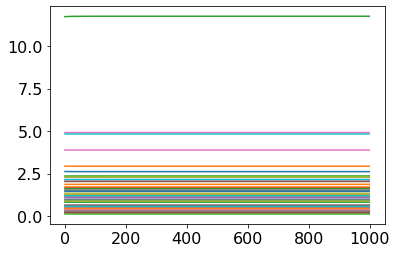

The solution converged.


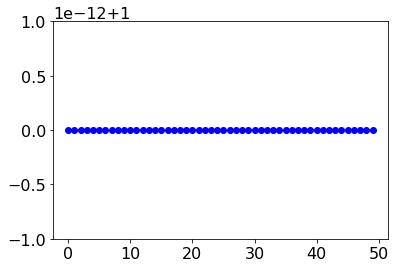

-0.4022646943827179


In [471]:
imp.reload(rmtchem)

n=50
c=2
nr=int(c*n)
ndrives=int(n/10)
seeds=10
seed0=1
steps1=1
steps2=1000
d0min=-1
d0max=3
d0s=10.0**np.arange(d0min,d0max,(d0max-d0min)/steps2)
d1min=1
d1max=100
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps2)

iseed=64

np.random.seed(seed0+iseed)
eta,nu,k,G=rmtchem.get_network(n,nr)
# X0=np.exp(-G)
# X0=np.random.random(size=n)
#inds=np.argsort(np.sum(eta+nu,axis=0))[-ndrives:]
# inds=np.argsort(-G)[-ndrives:]
# inds=np.random.choice(np.arange(n), size=ndrives, replace=False)
inds=np.argsort(np.exp(-G))[:ndrives]
# scales=np.random.random(size=ndrives)
scales=np.exp(-G[inds])

XD1s=np.zeros((steps1+steps2,n))
XD2s=np.zeros((steps1+steps2,n))
for m in range(steps1):
    XD1s[m,inds]=d0s[m]*scales
    XD2s[m,inds]=d0s[m]
for m in range( steps2):
    XD1s[steps1+m,inds]=d1s[m]*d0s[-1]*scales
    XD2s[steps1+m,inds]=d0s[-1]
    
m=1
Xs,success=rmtchem.integrate(X0*(1+(np.random.random(size=n)-0.5)*1e-2), eta, nu, k, XD1s[m], XD2s[m],100,0.1,prog=True)
sol=rmtchem.steady(X0, eta, nu, k, XD1s[m], XD2s[m])
plt.plot(Xs)
plt.show()
plt.plot(sol.x/Xs[-1],'bo')
print(sol.message)
plt.show()
X0=sol.x
evals,evecs=np.linalg.eig(rmtchem.jac(X0, eta, nu, k, XD1s[m], XD2s[m]))
print(np.max(np.real(evals)))

In [480]:
print(np.min(np.exp(-G)),np.max(np.exp(-G)))
np.argsort(np.exp(-G))
np.exp(-G)[np.argsort(np.exp(-G))[-ndrives:]]

0.1342083805715233 11.750855426770926


array([ 2.93794376,  3.88713308,  4.80424733,  4.91894961, 11.75085543])

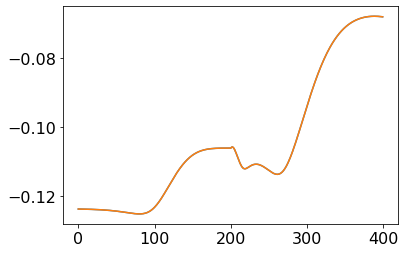

16.043820743000197 7.807143820315332e-12


In [21]:
imp.reload(rmtchem)

n=100
c=2
nr=int(c*n)
seed=2
ndrives=int(n/10)

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
X0=np.exp(-G)
inds=np.argsort(np.sum(eta+nu,axis=0))[-ndrives:]
scales=np.random.random(size=ndrives)

steps1=200
steps2=200
XD1s=np.zeros((steps1+steps2,n))
XD2s=np.zeros((steps1+steps2,n))
d0min=-1
d0max=3
d0s=10.0**np.arange(d0min,d0max,(d0max-d0min)/steps2)
d1min=1
d1max=20
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps2)
for m in range(steps1):
    XD1s[m,inds]=d0s[m]*scales
    XD2s[m,inds]=d0s[m]
for m in range( steps2):
    XD1s[steps1+m,inds]=d1s[m]*d0s[-1]*scales
    XD2s[steps1+m,inds]=d0s[-1]
    
start=timeit.default_timer()
evals1,evals2=rmtchem.hysteresis(X0, eta, nu, k, XD1s, XD2s)
stop=timeit.default_timer()
plt.plot(evals1)
plt.plot(np.flip(evals2,axis=0))
plt.show()
print(stop-start,np.max(np.real(evals1-np.flip(evals2,axis=0))))

driving
1.4141221527097514e-09


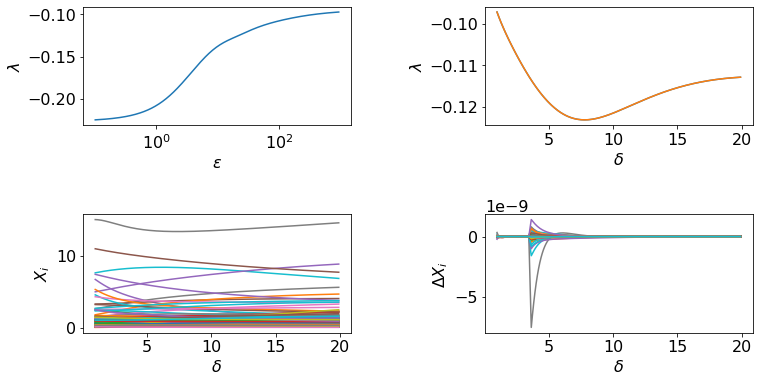

In [366]:
n=100
c=2
nr=int(c*n)
seed=7
np.random.seed(seed)

ndrives=3
eta,nu,k,G=rmtchem.get_network(n,nr)
X0=np.exp(-G)
inds=np.argsort(np.sum(eta+nu,axis=0))[-ndrives:]
# inds=np.argsort(G)[-ndrives:]
scales=np.random.random(size=ndrives)

steps=200
XD1s=np.zeros((steps,n))
XD2s=np.zeros((steps,n))
d0min=-1
d0max=3
d0s=10.0**np.arange(d0min,d0max,(d0max-d0min)/steps)
for m in range(steps):
    XD1s[m,inds]=d0s[m]*scales
    XD2s[m,inds]=d0s[m]

Xs1=rmtchem.quasistatic(X0, eta, nu, k, XD1s, XD2s)
mevals1=np.array([np.max(np.real(np.linalg.eig(rmtchem.jac(Xs1[m],eta,nu,k,XD1s[m], XD2s[m]))[0])[np.where(np.real(np.linalg.eig(rmtchem.jac(Xs1[m],eta,nu,k,XD1s[m], XD2s[m]))[0])!=0)]) for m in range(steps)])

print("driving")
steps=200
XD1s=np.zeros((steps,n))
XD2s=np.zeros((steps,n))
d1min=1
d1max=20
d1s=d1min+(d1max-d1min)*np.arange(steps)/steps
for m in range(steps):
    XD1s[m,inds]=d1s[m]*d0s[-1]*scales
    XD2s[m,inds]=d0s[-1]
Xs2=rmtchem.quasistatic(Xs1[-1], eta, nu, k, XD1s, XD2s)
mevals2=np.array([np.max(np.real(np.linalg.eig(rmtchem.jac(Xs2[m],eta,nu,k,XD1s[m], XD2s[m]))[0])[np.where(np.real(np.linalg.eig(rmtchem.jac(Xs2[m],eta,nu,k,XD1s[m], XD2s[m]))[0])!=0)]) for m in range(steps)])
XD3s=np.flip(XD1s,axis=0)
XD4s=np.flip(XD2s,axis=0)
Xs3=rmtchem.quasistatic(Xs2[-1], eta, nu, k, XD3s, XD4s)
mevals3=np.array([np.max(np.real(np.linalg.eig(rmtchem.jac(Xs3[m],eta,nu,k,XD3s[m], XD4s[m]))[0])[np.where(np.real(np.linalg.eig(rmtchem.jac(Xs3[m],eta,nu,k,XD3s[m], XD4s[m]))[0])!=0)]) for m in range(steps)])
print(np.max(Xs2-np.flip(Xs3,axis=0)))

fix,ax=plt.subplots(2,2,figsize=(12, 6))
plt.subplot(2,2,1)
plt.xlabel("$\epsilon$")
plt.ylabel("$\lambda$")
plt.xscale('log')
plt.plot(d0s,mevals1)
plt.subplot(2,2,2)
plt.xlabel("$\delta$")
plt.ylabel("$\lambda$")
plt.plot(d1s,mevals2)
plt.plot(np.flip(d1s),mevals3)
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.75)
plt.subplot(2,2,3)
plt.xlabel("$\delta$")
plt.ylabel("$X_i$")
plt.plot(d1s,Xs2)
plt.subplot(2,2,4)
plt.xlabel("$\delta$")
plt.ylabel("$\Delta X_i$")
plt.plot(d1s,Xs2-np.flip(Xs3,axis=0))
plt.show()
plt.show()

True The solution converged.


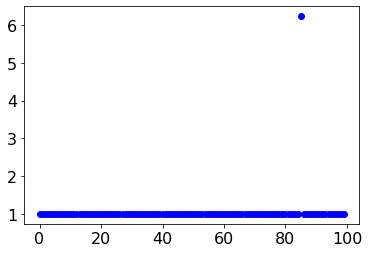

0 The solution converged.


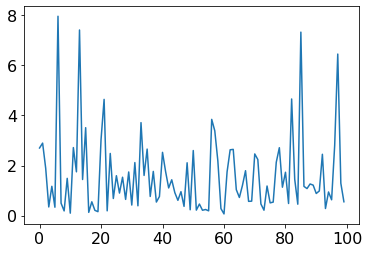

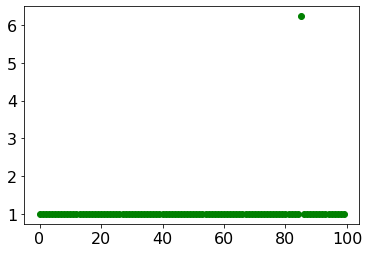

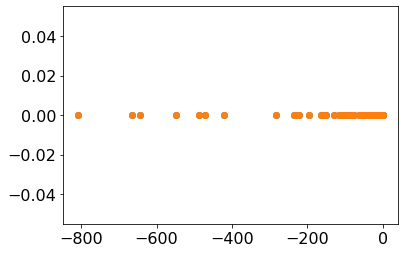

0.0 0.0


In [321]:
from scipy.optimize import root
seed=48
ndrives=3

m=0
m0=0
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
X0=np.exp(-G)
inds=np.argsort(np.sum(eta+nu,axis=0))[-ndrives:]
scales=np.random.random(size=ndrives)

XD1=XD1s[1]*0
XD2=XD2s[1]*0
X0=Xs2[1]
X0=np.exp(-G)
# X0=np.random.random(size=n)

sol=rmtchem.steady(X0,eta,nu,k,XD1,XD2)
print(sol.success,sol.message)
evals,evecs=np.linalg.eig(rmtchem.jac(sol.x,eta,nu,k,XD1,XD2))

plt.plot(sol.x/X0,'bo')
plt.show()
# X0=Xs2

count=0
sol2=rmtchem.steady(X0,eta,nu,k,XD1,XD2)    
X00=X0
while not sol2.success:
    Xi,success=rmtchem.integrate(X00,eta,nu,k,XD1,XD2,n,5000,100)
    X00=Xi[-1]
    sol2=rmtchem.steady(X00,eta,nu,k,XD1,XD2)    
    count=count+1
print(count, sol2.message)

plt.plot(sol2.x)
plt.show()
plt.plot(sol2.x/X0,'go')
plt.show()
evals4,evecs4=np.linalg.eig(rmtchem.jac(sol2.x,eta,nu,k,XD1,XD2))

plt.scatter(x=np.real(evals),y=np.imag(evals))
plt.scatter(x=np.real(evals4),y=np.imag(evals4))
plt.show()
print(np.max(np.real(evals)),np.max(np.real(evals4)))